In [2]:
#https://github.com/pomber/covid19
print('Initializing brazilian analysis!')
import numpy as np
import pandas as pd
import folium, html, json
import matplotlib.pyplot as plt
import datetime

Initializing brazilian analysis!


In [3]:
df = pd.read_csv('../data/brazil_corona19_data.csv')
df['date'] = df['date'].astype('datetime64[ns]')

today = df.date.max().date()
tomorrow = today + datetime.timedelta(days=1)
yesterday = today - datetime.timedelta(days=1)
qtdeMonitored = 10

# df.city_ibge_code = df.city_ibge_code.ast}ype('str')

df = df[(df['place_type']=='state')]

df.tail()

,date,state,city,place_type,cases,deaths,day,is_last,population,city_ibge_code,...,var_death_day,cases_thousand,deaths_thousand,case_day_thousand,death_day_thousand,avg7_cases,avg7_deaths,avg7_perc_death,avg7_case_day_thousand,avg7_death_day_thousand
345548,2020-07-10,TO,-,state,14939,251,111,False,1572866,17,...,1.0,9.498,0.160,0.273,0.004,379,5,1.73,0.241,0.003
345549,2020-07-11,TO,-,state,15132,255,112,False,1572866,17,...,-2.0,9.621,0.162,0.123,0.003,379,5,1.72,0.241,0.003
345550,2020-07-12,TO,-,state,15307,259,113,False,1572866,17,...,0.0,9.732,0.165,0.111,0.003,381,5,1.71,0.242,0.003
345551,2020-07-13,TO,-,state,15723,267,114,False,1572866,17,...,4.0,9.996,0.170,0.264,0.005,388,5,1.70,0.247,0.004
345552,2020-07-14,TO,-,state,16031,271,115,True,1572866,17,...,-4.0,10.192,0.172,0.196,0.003,370,5,1.70,0.235,0.003


In [4]:
# df_mapa[['date','state','city_ibge_code','death_day_thousand']]
df.state.unique()

array(['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG',
       'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR',
       'RS', 'SC', 'SE', 'SP', 'TO'], dtype=object)

In [5]:
state_geo = json.load(open('../data/brasil-estados.json'))
df_mapa = df[df.is_last == True].copy()#df[(df['date']==str(today))].copy()
states = df_mapa.state.unique()

for state in state_geo['features']: 
    latLon =  state['properties']['centroide']
    codarea = state['properties']['codarea']
    df_mapa.loc[df_mapa['city_ibge_code']==int(codarea),'lat'] = latLon[1]
    df_mapa.loc[df_mapa['city_ibge_code']==int(codarea),'lon'] = latLon[0]

df_mapa.tail()

,date,state,city,place_type,cases,deaths,day,is_last,population,city_ibge_code,...,deaths_thousand,case_day_thousand,death_day_thousand,avg7_cases,avg7_deaths,avg7_perc_death,avg7_case_day_thousand,avg7_death_day_thousand,lat,lon
246815,2020-07-15,RS,-,state,42239,1101,125,True,11377239,43,...,0.097,0.110,0.004,954,39,2.49,0.084,0.003,-29.705809,-53.319974
273916,2020-07-15,SC,-,state,47976,569,126,True,7164788,42,...,0.079,0.269,0.005,1595,19,1.16,0.223,0.003,-27.247330,-50.474101
293539,2020-07-15,SE,-,state,40139,1054,113,True,2298696,28,...,0.459,0.423,0.009,1092,25,2.65,0.475,0.011,-10.584717,-37.443872
299263,2020-07-15,SP,-,state,393176,18640,140,True,45919049,35,...,0.406,0.143,0.007,7401,264,4.80,0.161,0.006,-22.263541,-48.733659
345552,2020-07-14,TO,-,state,16031,271,115,True,1572866,17,...,0.172,0.196,0.003,370,5,1.70,0.235,0.003,-10.150000,-48.329160


In [6]:
m = folium.Map(location=[-15.75, -49.95], zoom_start=4)
df_mapa.city_ibge_code = df_mapa.city_ibge_code.astype('str') # para o mappgin

# folium.Choropleth(
#     geo_data=state_geo,
#     name='Contaminações',
#     data=df_brasil,
#     columns=['id_estado', 'avg7_cases'],
#     key_on='feature.properties.codarea',
#     fill_color='PuBu',#'YlGn',
#     fill_opacity=0.7,
#     line_opacity=0.3,
#     legend_name='media movel de casos (7 ultimos dias)'
# ).add_to(m)

folium.Choropleth(
    geo_data=state_geo,
    name='Mortes por mil habitantes (média móvel 7 dias)',
    data=df_mapa,
    columns=['city_ibge_code', 'avg7_death_day_thousand'],
    key_on='feature.properties.codarea',
    fill_color='YlOrRd',#'YlGn',
#     ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’.
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name= 'mortes em por mil habitandes (média móvel 7 dias < ' + today.strftime("%d/%m/%Y") + ')',
).add_to(m)

for state in states:
    dados = df_mapa[df_mapa['state']==state]
    detalhes = '<center><b>'+dados.state.values[0] +'</b></center>\n'
    detalhes += 'casos: ' + str(dados.cases.sum()) + ', mortes: ' + str(dados.deaths.sum())
    detalhes += ', mortes/1k hab: ' + str(dados.deaths_thousand.values[0])
    
    folium.CircleMarker(
        location=[dados.lat,dados.lon],
        radius=5,
#         popup=detalhes,
        color='#727b7d',
        fill=True,
        fill_color='black',
        tooltip=detalhes,
        icon=folium.Icon(color='blue',
             icon_color='black',
             icon='info-sign',
             prefix='es')
    ).add_to(m)

folium.LayerControl().add_to(m)

m.save('../analysis/maps/brazilMapDeaths.html')
m

In [7]:
m = folium.Map(location=[-15.75, -49.95], zoom_start=4)
folium.Choropleth(
    geo_data=state_geo,
    name='Contaminações por mil habitantes (média móvel 7 dias)',
    data=df_mapa,
    columns=['city_ibge_code', 'avg7_case_day_thousand'],
    key_on='feature.properties.codarea',
    fill_color='RdPu',#'YlGn',
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name= 'casos por mil habitantes (média móvel 7 dias < ' + today.strftime("%d/%m/%Y") + ')',
).add_to(m)
folium.LayerControl().add_to(m)

for state in states:
    dados = df_mapa[df_mapa['state']==state]
    detalhes = '<center><b>'+dados.state.values[0] +'</b></center>\n'
    detalhes += 'casos: ' + str(dados.cases.sum()) + ', mortes: ' + str(dados.deaths.sum())
    detalhes += ', casos/1k hab: ' + str(dados.cases_thousand.values[0])
    
#     detalhes = udetalhes
    
    folium.CircleMarker(
        location=[dados.lat,dados.lon],
        radius=5,
#         popup=detalhes,
        color='#727b7d',
        fill=True,
        fill_color='blue',
        tooltip=detalhes,
        icon=folium.Icon(color='blue',
             icon_color='black',
             icon='info-sign',
             prefix='es')
    ).add_to(m)
    
m.save('../analysis/maps/brazilMapCases.html')
m

In [8]:
# import imgkit
# print('Gerando imagens dos mapas do Brasil')
# options = {
#     'format': 'png',
# #     'crop-h': '3',
# #     'crop-w': '3',
# #     'crop-x': '3',
# #     'crop-y': '3',
#     'width':'300',
#     'encoding': "UTF-8",
#     'custom-header' : [
#         ('Accept-Encoding', 'gzip')
#     ],
# }
# imgkit.from_file('../analysis/maps/brazilMapDeathsContainer.html', '../analysis/maps/brazilMapDeaths.png', options=options)
# imgkit.from_file('../analysis/maps/brazilMapCasesContainer.html', '../analysis/maps/brazilMapCases.png', options=options)

----------------------------
### Brasil - Analysis and monitoring

In [9]:
#week variation
lastWeek = today - datetime.timedelta(days=7)

# cases and deaths
lastWeekCases = df[df['date']==str(lastWeek)].cases.sum()
lastWeekDeaths = df[df['date']==str(lastWeek)].deaths.sum()
todayCases = df[df['is_last']==True].cases.sum()
todayDeaths = df[df['is_last']==True].deaths.sum()
varCases = int((todayCases / lastWeekCases - 1) *100)
varDeaths = int((todayDeaths / lastWeekDeaths - 1) *100)
diffCases = todayCases - lastWeekCases
diffDeaths = todayDeaths - lastWeekDeaths

#### Top 5 deadliest states 

In [17]:
cols = ['state', 'date', 'day', 'population','case_day', 'cases', 'death_day', 'deaths', 'cases_thousand','deaths_thousand', 'perc_death']
addedStates = ['SP']

df_top_deaths = df[(df['is_last']==True)].sort_values('deaths_thousand', ascending = False)
df_top_deaths.reset_index(0, inplace=True)
df_top_deaths.index = df_top_deaths.index + 1
df_top_deaths = df_top_deaths[cols].head(qtdeMonitored)
df_top_deaths

,state,date,day,population,case_day,cases,death_day,deaths,cases_thousand,deaths_thousand,perc_death
1,CE,2020-07-15,122,9132078,2395,141832,104,7081,15.531,0.775,4.99
2,AM,2020-07-15,121,4144597,1144,86944,16,3080,20.978,0.743,3.54
3,RJ,2020-07-15,125,17264943,1627,134449,133,11757,7.787,0.681,8.74
4,RR,2020-07-14,113,605761,713,23681,5,403,39.093,0.665,1.70
5,PA,2020-07-15,120,8602865,2205,133039,48,5385,15.464,0.626,4.05
6,PE,2020-07-15,126,9557071,1384,74960,57,5772,7.843,0.604,7.70
7,AP,2020-07-15,117,845731,523,32408,5,488,38.320,0.577,1.51
8,ES,2020-07-15,132,4018650,1139,66352,14,2096,16.511,0.522,3.16
9,AC,2020-07-15,121,881935,193,16672,10,446,18.904,0.506,2.68
10,SE,2020-07-15,113,2298696,972,40139,21,1054,17.462,0.459,2.63


#### Top 5 most transmissible countries + Brazil

In [11]:
df_top_cases = df[(df['is_last']==True)].sort_values('cases_thousand', ascending = False)

df_top_cases.reset_index(0, inplace=True)
df_top_cases.index = df_top_cases.index + 1
df_top_cases = df_top_cases[cols].head(qtdeMonitored)
df_top_cases

,state,date,day,population,case_day,cases,death_day,deaths,cases_thousand,deaths_thousand,perc_death
1,RR,2020-07-14,113,605761,713,23681,5,403,39.093,0.665,1.70
2,AP,2020-07-15,117,845731,523,32408,5,488,38.320,0.577,1.51
3,DF,2020-07-15,130,3015268,1725,75379,41,1001,24.999,0.332,1.33
4,AM,2020-07-15,121,4144597,1144,86944,16,3080,20.978,0.743,3.54
5,AC,2020-07-15,121,881935,193,16672,10,446,18.904,0.506,2.68
6,SE,2020-07-15,113,2298696,972,40139,21,1054,17.462,0.459,2.63
7,ES,2020-07-15,132,4018650,1139,66352,14,2096,16.511,0.522,3.16
8,PB,2020-07-15,126,4018127,1477,63939,41,1383,15.913,0.344,2.16
9,RO,2020-07-15,112,1777225,389,27917,4,667,15.708,0.375,2.39
10,CE,2020-07-15,122,9132078,2395,141832,104,7081,15.531,0.775,4.99


#### Brazilian states to be analised

#### Cases and deaths 

In [36]:
#inform the countries you want to analise
monitoredStates = df_top_deaths['state'].head(qtdeMonitored).to_numpy()#.append('SP')
monitoredStates = np.append(monitoredStates, 'SP')
monitoredStates

array(['CE', 'AM', 'RJ', 'RR', 'PA', 'PE', 'AP', 'ES', 'AC', 'SE', 'SP'],
      dtype=object)

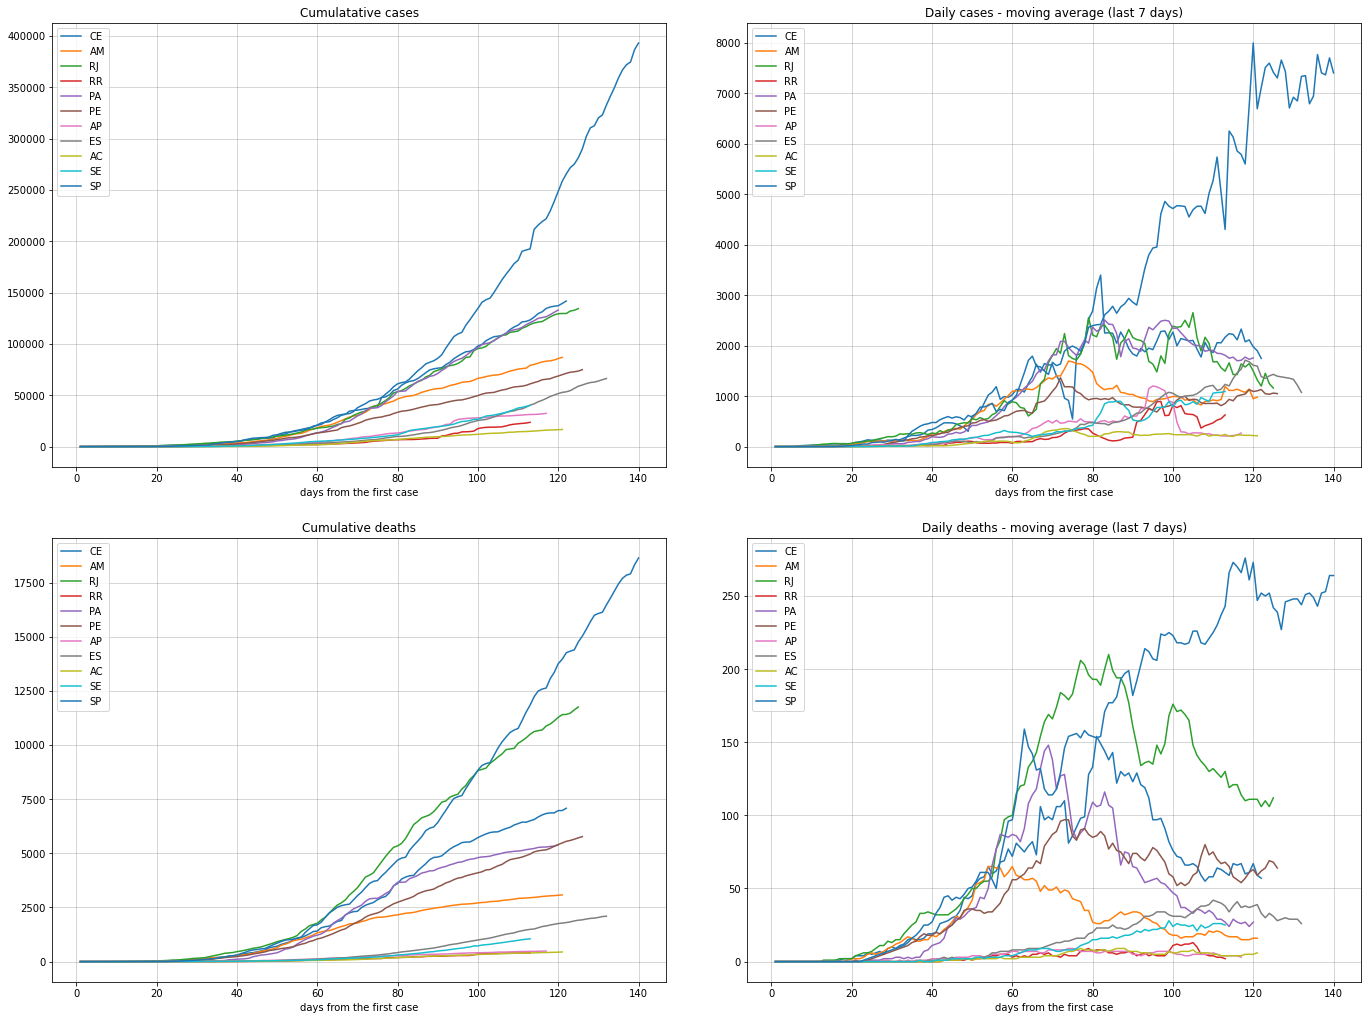

In [37]:
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(20, 20))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 15))
fig.tight_layout(pad=5.0)

ax1.set_title("Cumulatative cases")
ax1.set_xlabel("days from the first case")
ax1.grid(color='gray', alpha = 0.4)

ax2.set_title("Daily cases - moving average (last 7 days)")
ax2.set_xlabel("days from the first case")
ax2.grid(color='gray', alpha = 0.4)

ax3.set_title("Cumulative deaths")
ax3.set_xlabel("days from the first case")
ax3.grid(color='gray', alpha = 0.4)

ax4.set_title("Daily deaths - moving average (last 7 days)")
ax4.set_xlabel("days from the first case")
ax4.grid(color='gray', alpha = 0.4)

# ax5.set_title("Cumulative recoveries")
# ax5.set_xlabel("days from the first case")
# ax5.grid(color='gray', alpha = 0.4)

# ax6.set_title("Recoveries - moving average (last 7 days)")
# ax6.set_xlabel("days from the first case")
# ax6.grid(color='gray', alpha = 0.4)

for state in monitoredStates:
    dados = df[(df['state'] == state)]
    ax1.plot(dados.day, dados.cases, label = state)
    ax2.plot(dados.day, dados.avg7_cases, label = state)
    ax3.plot(dados.day, dados.deaths, label = state)
    ax4.plot(dados.day, dados.avg7_deaths, label = state)
#     ax5.plot(df[indexes].day, df[indexes].recoveries, label = state)
#     ax6.plot(df[indexes].day, df[indexes].avg7_recoveries, label = state)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
# ax5.legend()
# ax6.legend()
fig.savefig('../analysis/brazilian_states_cases_deaths.png')

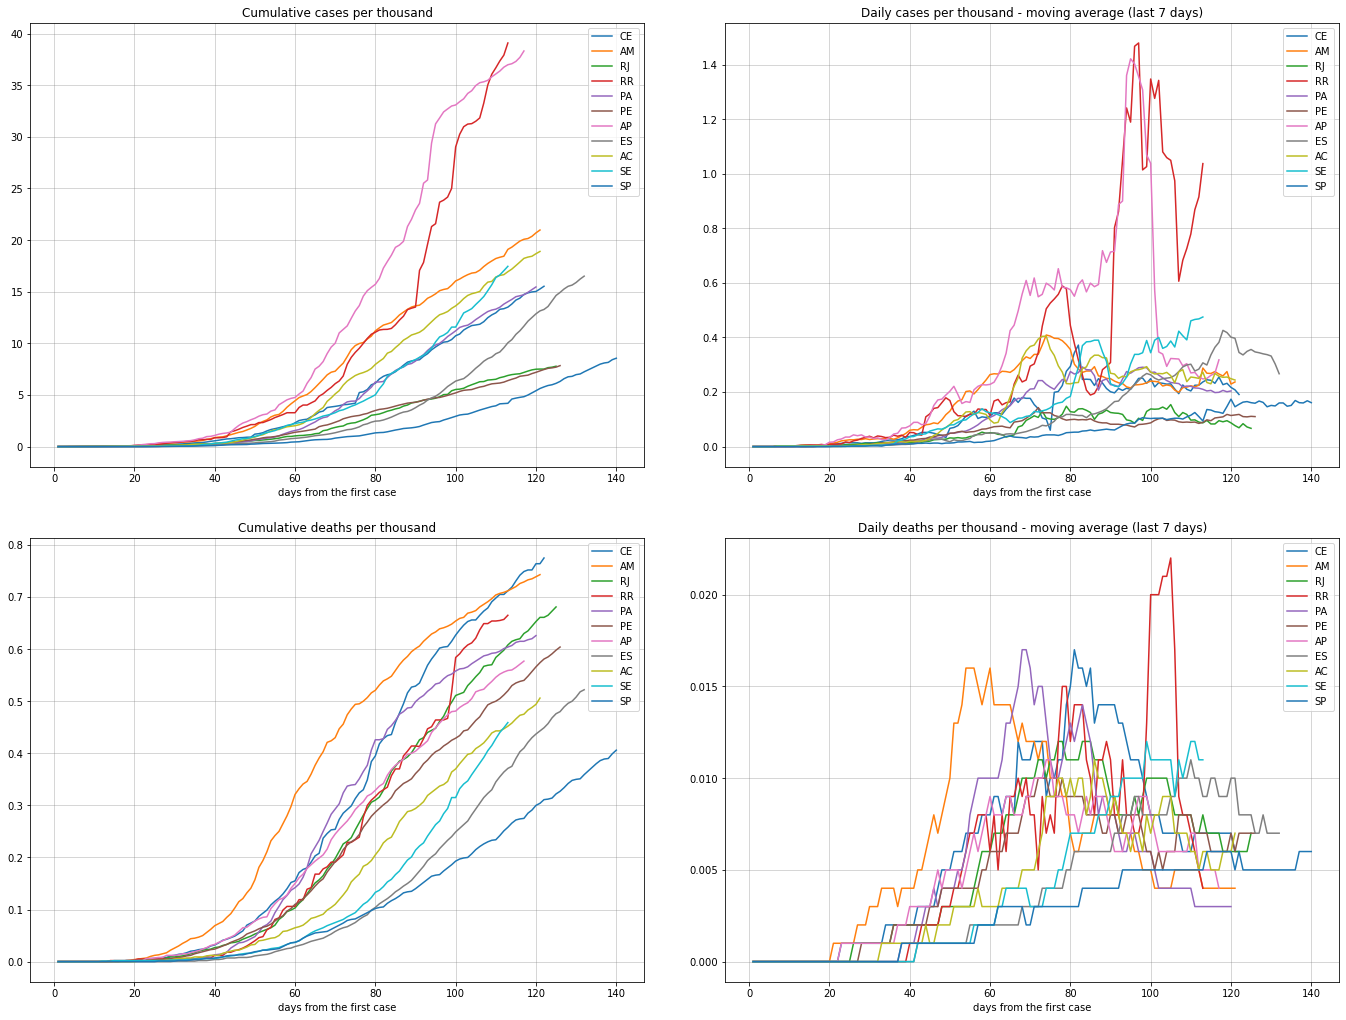

In [38]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 15))
fig.tight_layout(pad=5.0)

ax1.set_title("Cumulative cases per thousand")
ax1.set_xlabel("days from the first case")
ax1.grid(color='gray', alpha = 0.4)

ax2.set_title("Daily cases per thousand - moving average (last 7 days)")
ax2.set_xlabel("days from the first case")
ax2.grid(color='gray', alpha = 0.4)

ax3.set_title("Cumulative deaths per thousand")
ax3.set_xlabel("days from the first case")
ax3.grid(color='gray', alpha = 0.4)

ax4.set_title("Daily deaths per thousand - moving average (last 7 days)")
ax4.set_xlabel("days from the first case")
ax4.grid(color='gray', alpha = 0.4)

# ax5.set_title("Recoveries per thousand")
# ax5.set_xlabel("days from the first case")
# ax5.grid(color='gray', alpha = 0.4)

# ax6.set_title("Recoveries per thousand - moving average (last 7 days)")
# ax6.set_xlabel("days from the first case")
# ax6.grid(color='gray', alpha = 0.4)

for state in monitoredStates:
    dados = df[(df['state'] == state)]# & (df['codmun']==0)]
    ax1.plot(dados.day, dados.cases_thousand, label = state)
    ax2.plot(dados.day, dados.avg7_case_day_thousand, label = state)
    ax3.plot(dados.day, dados.deaths_thousand, label = state)
    ax4.plot(dados.day, dados.avg7_death_day_thousand, label = state)
#     ax5.plot(df[indexes].day, df[indexes].recoveries_thousand, label = state)
#     ax6.plot(df[indexes].day, df[indexes].avg7_recoveries_thousand, label = state)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
# ax5.legend()
# ax6.legend()

fig.savefig('../analysis/brazil_cases_deaths_thousand.png')

### Generating the HTML file

In [15]:
f = open('../html/brazil_analysis.html', 'w')
f1 = open('../html/templates/brazil_analysis_01.html', 'r').read()
f2 = open('../html/templates/brazil_analysis_02.html', 'r').read()
f3 = open('../html/templates/brazil_analysis_03.html', 'r').read()

readme = f1
readme += '<p>Estas análises são relativas aos dados da pandemia Covid19 no Brasil até a data de <strong>' + today.strftime("%d/%m/%Y") + '</strong>.</p>'
readme += '          <p style="font-size:14px"><i>Estas informações são para uso próprio e não devem ser utilizadas para direcionamentos médicos e/ou políticas públicas.</i></p>'
readme += '</div></div>'
readme += '<div class="container"> '
readme += '<h3>Análise semanal</h3><br>'
readme += '<table border="1" class="dataframe " width="60%">'
readme += '  <thead>'
readme += '    <tr>'
readme += '      <th style="text-align: center;" width="25%"></th>'
readme += '      <th style="text-align: center;">'+ lastWeek.strftime("%d/%m/%Y")+ '</th>'
readme += '      <th style="text-align: center;">'+ today.strftime("%d/%m/%Y") +'</th>'
readme += '      <th style="text-align: center;"> variação </th>'
readme += '    </tr>'
readme += '  </thead>'
readme += '  <tbody>'
readme += '    <tr style="text-align: right;">'
readme += '      <td style="font-weight: bold; text-align: right;" width="25%">casos</td>'
readme += '      <td>'+str(lastWeekCases)+'</td>'
readme += '      <td>'+str(todayCases)+'</td>'
readme += '      <td>'+str(diffCases)+ ' (' +str(varCases)+'%)</td>'
readme += '    </tr>'
readme += '    <tr style="text-align: right;">'
readme += '      <td style="font-weight: bold; text-align: right;" width="25%">mortes</td>'
readme += '      <td>'+str(lastWeekDeaths)+'</td>'
readme += '      <td>'+str(todayDeaths)+'</td>'
readme += '      <td>'+str(diffDeaths)+ ' ('+str(varDeaths)+'%)</td>'
readme += '    </tr>'
readme += '  </tbody>'
readme += '</table> </div><br>' 
readme += f2
readme += '        <div class="container">'
readme += '          <h3>Top ' + str(qtdeMonitored) + ' estados mais mortais do Brasil</h3>'
readme += '          <p>O ranking é feito a partir da quantidade total de mortes por cada mil habitantes de cada estado.</p>'
readme += df_top_deaths.to_html(classes='table', decimal=',', justify='justify')
readme += '        </div>'
readme += '        <br>'
readme += '        <div class="container">'
readme += '          <h3>Top ' + str(qtdeMonitored) + ' estados mais transmissíveis do Brasil</h3>'
readme += '          <p>O ranking é feito a partir da quantidade total de casos por cada mil habitantes de cada estado.</p>'
readme += df_top_cases.to_html(classes='table', decimal=',', justify='justify')
readme += '        </div>'
readme += '        <br>'
readme += f3

f.write(readme)
f.close()

###########################################

f = open('../html/brazil_analysis_EN.html', 'w')
f1 = open('../html/templates/brazil_analysis_EN_01.html', 'r').read()
f2 = open('../html/templates/brazil_analysis_EN_02.html', 'r').read()
f3 = open('../html/templates/brazil_analysis_EN_03.html', 'r').read()

readme = f1
readme += '<p>These analysis are related to Brazil Convid19 pandemic data up to <strong>' + today.strftime("%m/%d/%Y") + '</strong>.</p>'
readme += '             <p style="font-size:14px"><i>This information is for own use only and shall NOT be used for medical and public policy guidances.</i></p>'
readme += '</div></div>'
readme += '<div class="container"> '
readme += '<h3>Weekly analysis</h3><br>'
readme += '<table border="1" class="dataframe " width="60%">'
readme += '  <thead>'
readme += '    <tr>'
readme += '      <th style="text-align: center;" width="25%"></th>'
readme += '      <th style="text-align: center;">'+ lastWeek.strftime("%d/%m/%Y")+ '</th>'
readme += '      <th style="text-align: center;">'+ today.strftime("%d/%m/%Y") +'</th>'
readme += '      <th style="text-align: center;"> variations </th>'
readme += '    </tr>'
readme += '  </thead>'
readme += '  <tbody>'
readme += '    <tr style="text-align: right;">'
readme += '      <td style="font-weight: bold; text-align: right;" width="25%">cases</td>'
readme += '      <td>'+str(lastWeekCases)+'</td>'
readme += '      <td>'+str(todayCases)+'</td>'
readme += '      <td>'+str(diffCases)+ ' (' +str(varCases)+'%)</td>'
readme += '    </tr>'
readme += '    <tr style="text-align: right;">'
readme += '      <td style="font-weight: bold; text-align: right;" width="25%">deaths</td>'
readme += '      <td>'+str(lastWeekDeaths)+'</td>'
readme += '      <td>'+str(todayDeaths)+'</td>'
readme += '      <td>'+str(diffDeaths)+ ' ('+str(varDeaths)+'%)</td>'
readme += '    </tr>'
readme += '  </tbody>'
readme += '</table> </div><br>' 
readme += f2
readme += '        <div class="container">'
readme += '          <h3>Top ' + str(qtdeMonitored) + ' deadliest states of Brazil</h3>'
readme += '          <p>This ranking is made from the total of deaths per each thousand of population of each state.</p>'
readme += df_top_deaths.to_html(classes='table', decimal=',', justify='justify')
readme += '        </div>'
readme += '        <br>'
readme += '        <div class="container">'
readme += '          <h3>Top ' + str(qtdeMonitored) + ' most transmissible states of Brazil</h3>'
readme += '          <p>This ranking is made from the total of cases per each thousand of population of each state.</p>'
readme += df_top_cases.to_html(classes='table', decimal=',', justify='justify')
readme += '        </div>'
readme += '        <br>'
readme += f3

f.write(readme)
f.close()

print('Brazilian analysis done!')

Brazilian analysis done!


In [16]:
# df[df['state']=='SP'][['date','death_day']]